# Fine-Tuning


### Load Metadata


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

# Load and preprocess data
train_metadata_path = '/content/drive/My Drive/Term 7/Computer Vision/Skin Cancer Detection/Datasets/train-metadata.csv'
train_metadata = pd.read_csv(train_metadata_path, low_memory=False)
train_metadata.columns = train_metadata.columns.str.strip()

common_columns = [
    "isic_id", "patient_id", "age_approx", "sex", "anatom_site_general",
    "clin_size_long_diam_mm", "image_type", "tbp_tile_type", "tbp_lv_A",
    "tbp_lv_B", "tbp_lv_perimeterMM", "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt", "tbp_lv_symm_2axis",
    "tbp_lv_symm_2axis_angle", "tbp_lv_x", "tbp_lv_y", "tbp_lv_z", "target"
]
train_metadata = train_metadata[common_columns].dropna()

categorical_columns = ['sex', 'anatom_site_general', 'image_type', 'tbp_tile_type']
label_encoder = LabelEncoder()
for col in categorical_columns:
    train_metadata[col] = label_encoder.fit_transform(train_metadata[col])

train_metadata.head()

Mounted at /content/drive


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_B,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,target
0,ISIC_0015670,IP_1235828,60.0,1,2,3.04,0,1,20.244422,26.922447,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0
1,ISIC_0015845,IP_8170065,60.0,1,1,1.10,0,1,31.712570,26.331000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,0
2,ISIC_0015864,IP_6724798,60.0,1,3,3.40,0,0,22.575830,37.970460,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,0
3,ISIC_0015902,IP_4111386,65.0,1,0,3.22,0,0,14.242329,21.448144,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,0
4,ISIC_0024200,IP_8313778,55.0,1,0,2.73,0,1,24.725520,26.464900,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,0


### Data Preprocessing

In [ ]:
numerical_columns = [
    "age_approx", "clin_size_long_diam_mm", "tbp_lv_A", "tbp_lv_B",
    "tbp_lv_perimeterMM", "tbp_lv_radial_color_std_max", "tbp_lv_stdL",
    "tbp_lv_stdLExt", "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
]
scaler = StandardScaler()
train_metadata[numerical_columns] = scaler.fit_transform(train_metadata[numerical_columns])

In [ ]:
# Separate features and target
X = train_metadata.drop(columns=["target", "isic_id", "patient_id"])
y = train_metadata["target"]

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

### Fine-Tuned Model

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = NeuralNetwork(input_dim)

# Loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with early stopping
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=20, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

# Train the model
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=20, patience=5)

Epoch [1/20], Train Loss: 0.1939, Val Loss: 0.1173
Epoch [2/20], Train Loss: 0.0915, Val Loss: 0.0683
Epoch [3/20], Train Loss: 0.0587, Val Loss: 0.0491
Epoch [4/20], Train Loss: 0.0439, Val Loss: 0.0377
Epoch [5/20], Train Loss: 0.0356, Val Loss: 0.0312
Epoch [6/20], Train Loss: 0.0302, Val Loss: 0.0283
Epoch [7/20], Train Loss: 0.0264, Val Loss: 0.0249
Epoch [8/20], Train Loss: 0.0236, Val Loss: 0.0233
Epoch [9/20], Train Loss: 0.0214, Val Loss: 0.0201
Epoch [10/20], Train Loss: 0.0195, Val Loss: 0.0208
Epoch [11/20], Train Loss: 0.0180, Val Loss: 0.0191
Epoch [12/20], Train Loss: 0.0168, Val Loss: 0.0191
Epoch [13/20], Train Loss: 0.0158, Val Loss: 0.0171
Epoch [14/20], Train Loss: 0.0146, Val Loss: 0.0157
Epoch [15/20], Train Loss: 0.0138, Val Loss: 0.0168
Epoch [16/20], Train Loss: 0.0129, Val Loss: 0.0154
Epoch [17/20], Train Loss: 0.0122, Val Loss: 0.0199
Epoch [18/20], Train Loss: 0.0116, Val Loss: 0.0144
Epoch [19/20], Train Loss: 0.0112, Val Loss: 0.0161
Epoch [20/20], Train 

### Evaluation

In [ ]:
def custom_metric(y_true, y_pred_proba, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.
    """
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    max_fpr = 1 - min_tpr
    v_gt = abs(y_true - 1)
    v_pred = 1.0 - y_pred_proba

    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred_proba = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            y_true.extend(labels.numpy())
            y_pred_proba.extend(torch.sigmoid(outputs).numpy())
    return np.array(y_true), np.array(y_pred_proba)

# Evaluate on the test set
y_test_true, y_test_pred_proba = evaluate_model(model, test_loader)

# Calculate metrics
accuracy = accuracy_score(y_test_true, (y_test_pred_proba > 0.5))
precision = precision_score(y_test_true, (y_test_pred_proba > 0.5))
recall = recall_score(y_test_true, (y_test_pred_proba > 0.5))
f1 = f1_score(y_test_true, (y_test_pred_proba > 0.5))
roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
pauc = custom_metric(y_test_true, y_test_pred_proba, min_tpr=0.8)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"pAUC (min TPR = 0.8): {pauc:.4f}")

Accuracy: 0.9978
Precision: 0.9956
Recall: 0.9999
F1 Score: 0.9978
ROC-AUC: 0.9993
pAUC (min TPR = 0.8): 0.1997


In [ ]:
# Save the trained model
save_path = '/content/drive/My Drive/metadata_model.pth'
torch.save(model.state_dict(), save_path)

print(f"Model saved at {save_path}")

Model saved at /content/drive/My Drive/metadata_model.pth


## Checks

In [ ]:
# List all columns and check for any that may encode the target variable
print("Columns in dataset:", train_metadata.columns)


Columns in dataset: Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_B', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max',
       'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis',
       'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
       'target'],
      dtype='object')


In [ ]:
# Check for overlap between train, val, and test sets
overlap_train_val = X_train[X_train.isin(X_val)].dropna()
overlap_train_test = X_train[X_train.isin(X_test)].dropna()
overlap_val_test = X_val[X_val.isin(X_test)].dropna()

print(f"Overlap between train and val sets: {overlap_train_val.shape[0]}")
print(f"Overlap between train and test sets: {overlap_train_test.shape[0]}")
print(f"Overlap between val and test sets: {overlap_val_test.shape[0]}")


Overlap between train and val sets: 0
Overlap between train and test sets: 0
Overlap between val and test sets: 0


In [ ]:
from sklearn.preprocessing import StandardScaler

# Fit scaler only on training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Confirm that scaler is not fitted on test/validation sets
print(f"First row after scaling: {X_train_scaled[0]}")


First row after scaling: [-0.90330605 -1.29127647  0.02699994  1.05004845  0.          1.4709414
  0.70990879 -0.99580831  1.25199528  1.08014705  0.16788921  0.14192514
  0.31273703 -0.19968177 -1.30517925 -1.89911561  0.1643646 ]


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check shape of resampled data
print(f"Resampled training data shape: {X_resampled.shape}")


Resampled training data shape: (610452, 17)


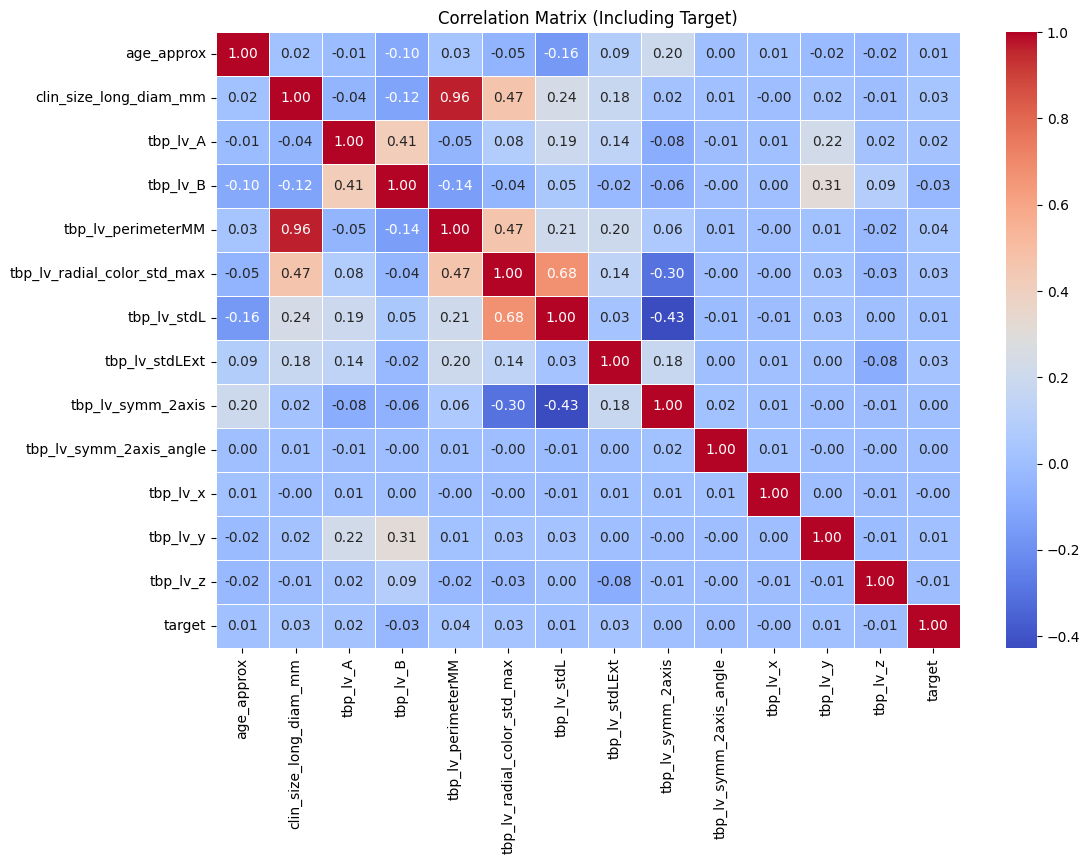

Feature correlations with target:
target                         1.000000
tbp_lv_perimeterMM             0.036745
clin_size_long_diam_mm         0.033071
tbp_lv_stdLExt                 0.026801
tbp_lv_radial_color_std_max    0.025604
tbp_lv_A                       0.020129
tbp_lv_stdL                    0.012556
tbp_lv_y                       0.009869
age_approx                     0.008190
tbp_lv_symm_2axis              0.002755
tbp_lv_symm_2axis_angle        0.001428
tbp_lv_x                      -0.002512
tbp_lv_z                      -0.008122
tbp_lv_B                      -0.026582
Name: target, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlation between numerical features and target
numerical_columns_with_target = numerical_columns + ['target']
correlation_matrix = train_metadata[numerical_columns_with_target].corr()

# Visualize the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix (Including Target)")
plt.show()

# Display correlations with the target
target_correlations = correlation_matrix['target'].sort_values(ascending=False)
print("Feature correlations with target:")
print(target_correlations)
